# Métodos de solução aproximada: SARSA semi-gradiente

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="mountain_car.gif" width="400">

Objetivo: usar um método de semi-gradiente para estimar uma política $\hat{q} \approx q_*$ para controlar um carro de montanha russa. A função de aproximação é baseada na ideia do *tile coding*.

## Características do pêndulo:

### Espaço de observações

| Número | Observação | Min | Max |
| :-: | :- | :-: | :-: |
| 0	| Posição do carrinho | -1.2 | 0.6 |
| 1	| Velocidade do carrinho | -0.07 | 0.07|

### Espaço de ações
| Número | Ação |
| :-: | :- |
| 0	| Acelera carrinho para a esquerda |
| 1	| Não acelera |
| 2	| Acelera carrinho para a direita |

### Função de recompensa

- Devolve -1 para cada passo antes do carrinho atingir a bandeira (objetivo é chegar o mais rápido possível).
- Episódio termina quando o carrinho atinge a bandeira.
- Máximo de 200 passos.

Importando bibliotecas.

In [1]:
try:
    import gymnasium as gym
except:
    import gym
import numpy as np
from functools import partial
from TileCoding import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

Criando a classe para o semi-gradient Sarsa.

In [2]:
class SemiGradient(object):
    def __init__(self, parameters, maxtiles=1024, numtilings=4):

        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']

        # cria ambiente
        if parameters['render']:
            self.env = gym.make('MountainCar-v0', render_mode='human')
        else:
            self.env = gym.make('MountainCar-v0')
        
        # modifica o numeor maximo de passos do ambiente (default de 200)
        self.env._max_episode_steps = self.max_iter

        # tamanho dos espacos de estados e acoes
        self.num_actions = self.env.action_space.n

        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.eps = np.max(parameters['eps'])
        self.alpha = parameters['alpha']

        # log file
        self.logfile = parameters['q-file']

        # tile parameters
        self.maxtiles = maxtiles
        self.numtilings = numtilings
        self.hashTable = IHT(self.maxtiles)

        # reseta a politica
        self.reset_policy()

    ##########################################
    # get indices of active tiles for given state and action
    def getActiveTiles(self, states, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        x = []
        for i, s in enumerate(states):
            min_value = self.env.observation_space.low[i]
            max_value = self.env.observation_space.high[i]
            x.append(s * self.numtilings/(max_value - min_value))

        return tiles(self.hashTable, self.numtilings, x, [action])

    ##########################################
    # q(S,A,w) = x(S,A)^T w
    def Q(self, s, a):
        return np.matmul(self.features(s, a), self.w)

    ##########################################
    # delta_q(S,A,w) = x(S,A)
    def delta(self, s, a):
        return np.array(self.features(s, a))

    ##########################################
    def features(self, s, a):
        tileIndices = self.getActiveTiles(s, a)
        feature = [0] * self.maxtiles
        for tile_index in tileIndices:
            feature[tile_index] = 1
        return feature

    ##########################################
    # reseta a funcao acao-valor
    def reset_policy(self):

        self.w = np.zeros(self.maxtiles)
        
        # carrega os parametros da função Q
        if self.parameters['load_Q']:
            try:
                with open(self.logfile, 'rb') as f:
                    data = np.load(f)
                    self.w = data['w']
                    self.episode = data['episodes']
            except: None

    ##########################################
    # retorna a politica corrente
    def curr_policy(self):
        return partial(self.TabularEpsilonSoftPolicy)

    ########################################
    # salva parametros
    def save(self):
        with open(self.logfile, 'wb') as f:
            np.savez(f, w=self.w, episodes=self.episode)

    ##########################################
    def __del__(self):
        self.env.close()

Probabilidade de escolha de uma ação $a$ baseada na política $\varepsilon$-soft:
$$
\pi(a|S_t) \gets 
                        \begin{cases}
                            1 - \varepsilon + \varepsilon/|\mathcal{A}|,  & \text{se}~ a = \arg\max\limits_{a} Q(S_t,a),\\
                            \varepsilon/|\mathcal{A}|, & \text{caso contrário.}
                        \end{cases}
$$

In [3]:
class SemiGradient(SemiGradient):
    ##########################################
    # escolha da açao (epsilon-soft)
    def TabularEpsilonSoftPolicy(self, state):

        # acao otima corrente A*
        Astar = np.argmax([self.Q(state, a) for a in range(self.num_actions)])

        # probabilidades de escolher as acoes
        p1 = 1.0 - self.eps + self.eps/self.num_actions
        p2 = self.eps/self.num_actions
        prob = [p1 if a == Astar else p2 for a in range(self.num_actions)]
        
        return np.random.choice(self.num_actions, p=np.array(prob))

Executando um episódio.

In [4]:
class SemiGradient(SemiGradient):
    ##########################################
    def runEpisode(self):

        # decaimento linear do eps
        self.eps = np.linspace(np.max(parameters['eps']), np.min(parameters['eps']), 
                               parameters['episodes'])[self.episode-1]
        
        # novo episodio
        self.episode += 1

        # pega a politica corrente (on-policy)
        self.policy = self.curr_policy()

        # inicia o ambiente (começa aleatoriamente)
        S, _ = self.env.reset()
        
        # \pi(s)
        A = self.policy(S)

        # lista de rewards
        rewards = []

        for _ in range(self.max_iter):

            # passo de interacao com o ambiente
            Sl, R, done, _, info = self.env.step(A)

            # Salva rewards
            rewards.append(R)

            # chegou a um estado terminal?
            if done:
                # update
                self.w = self.w + self.alpha*(R - self.Q(S,A))*self.delta(S,A)
                break

            # update
            Al = self.policy(Sl)
            self.w = self.w + self.alpha*(R + self.gamma*self.Q(Sl,Al) - self.Q(S,A))*self.delta(S,A)

            # proximo estado e ação
            S = Sl
            A = Al

        if self.parameters['save_Q']:
            self.save()

        return np.sum(np.array(rewards))

Programa principal:
- episodes: número de episódios
- max_iter: máximo de iterações até o fim do episódio
- gamma: fator de desconto
- eps: $\varepsilon$
- alpha: $\alpha$
- render: renderiza animação
- save_Q: salva parâmetros $w$ da função *Q*
- load_Q: carrega parâmetros $w$ da função *Q*
- q-file: arquivo dos parametros $w$ da função *Q*

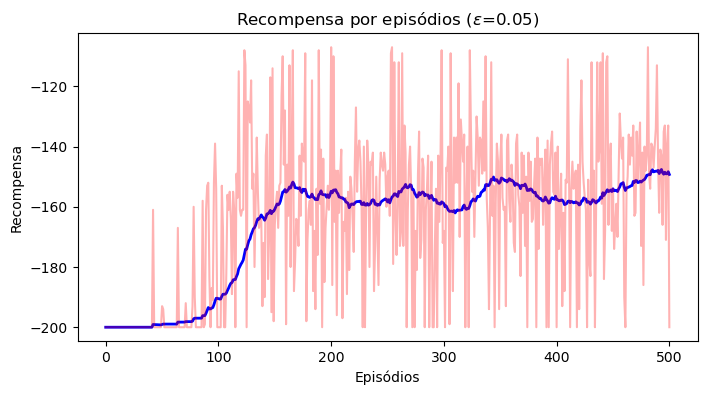

In [5]:
if __name__ == '__main__':

    plt.ion()
    
    # parametros
    parameters = {'episodes'  : 500,
                  'max_iter'  : 200,
                  'gamma'     : 0.99,
                  'eps'       : [1.0e-1, 5.0e-2],
                  'alpha'     : 2.0e-2,
                  'render'    : False,
                  'save_Q'    : True,
                  'load_Q'    : False,
                  'q-file'    : 'w_parameters.npy'}

    # semi-gradient Sarsa algorithm
    mc = SemiGradient(parameters)

    # historico dos reforços
    rewards = []
    avg_rewards = []

    while mc.episode <= parameters['episodes']:
        # roda um episodio
        total_reward = mc.runEpisode()

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_rewards.append(np.mean(rewards[-50:]))

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title(f"Recompensa por episódios ($\\epsilon$={mc.eps:.2f})")
        plt.xlabel('Episódios')
        plt.ylabel('Recompensa')

        plt.show()
        plt.pause(.1)

    plt.ioff()